In [1]:
import os
import sys
from glob import glob
import tensorflow as tf
import numpy as np
# import pandas as pd
from pathlib import Path
import cv2
#import keras
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Input, Flatten,
                                     Dropout, UpSampling2D, GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from keras import backend as K
from matplotlib import pyplot as plt
from sklearn.datasets import load_files
import platform

2023-08-31 20:10:38.006816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f'Python platform: {platform.platform()}')
print(f'Tensorflow version: {tf.__version__}')
#print(f"Keras version {keras.__version__}")
print()
print(f'System version: {sys.version}')
# print(f'Panda version: {pd.__version__}')
# print(f'Scikit-learn: {sk.__version__}')
gpu = len(tf.config.list_physical_devices("gpu")) > 0
print("GPU is ", "available" if gpu else "NOT AVAILABLE")

Python platform: Linux-6.2.0-31-generic-x86_64-with-glibc2.35
Tensorflow version: 2.12.0

System version: 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
GPU is  NOT AVAILABLE


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
basedir = Path(os.getcwd())
images_dir = Path(os.path.join(basedir, 'OriginalDataset'))
train_dir = Path(os.path.join(basedir, 'OriginalDataset/training_set'))
test_dir = Path(os.path.join(basedir, 'OriginalDataset/testing_set'))

In [5]:
def load_dataset(path):
    data = load_files(path)
    face_files = np.array(data['filenames'])
    face_targets = tf.keras.utils.to_categorical(np.array(data['target']), 5)
    return face_files, face_targets

In [6]:
#load datasets
train_files, train_targets = load_dataset(train_dir)
test_files, test_targets = load_dataset(test_dir)

In [7]:
face_type = [item[29:-1] for item in sorted(glob('OriginalDataset/training_set/*/'))]
face_type

['Heart', 'Oblong', 'Oval', 'Round', 'Square']

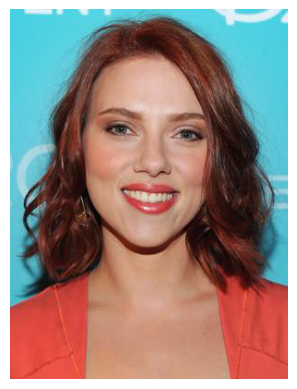

In [8]:
img = cv2.imread(train_files[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [10]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            label_mode= 'categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)



Found 3240 files belonging to 5 classes.


2023-08-31 20:10:49.160825: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           label_mode= 'categorical',
                                                           validation_split = 0.33,
                                                           subset = "training",
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                           seed = 1)


Found 1000 files belonging to 5 classes.
Using 670 files for training.


In [12]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                          shuffle=True,
                                                          label_mode= 'categorical',
                                                          validation_split = 0.33,
                                                          subset = "validation",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          seed = 1)

Found 1000 files belonging to 5 classes.
Using 330 files for validation.


In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
def create_model():
  inputs = Input(shape=(224, 224, 3))
  x1 = data_augmentation(inputs)
  x2 = preprocess_input(x1)
  base_model_layer = base_model(x2, training=False)
  pooling_layer = GlobalAveragePooling2D()(base_model_layer)
  dropout_layer = Dropout(0.1)(pooling_layer)
  Layer_1 = Dense(512, activation='relu')(dropout_layer)
  outputs = Dense(5, activation='softmax')(Layer_1)
  model = Model(inputs, outputs)
  return model

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
preprocess_input = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## MOBILENETV2 model feature extraction

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-08-31 20:11:09.227680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3240]
	 [[{{node Placeholder/_0}}]]
2023-08-31 20:11:09.228386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3240]
	 [[{{node Placeholder/_0}}]]


(32, 7, 7, 1280)


In [22]:
label_batch

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [23]:
image_batch

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[2.31000000e+02, 2.35000000e+02, 2.36000000e+02],
         [2.31000000e+02, 2.35000000e+02, 2.36000000e+02],
         [2.31000000e+02, 2.35000000e+02, 2.36000000e+02],
         ...,
         [2.27000000e+02, 2.30000000e+02, 2.35000000e+02],
         [2.27000000e+02, 2.30000000e+02, 2.35000000e+02],
         [2.27000000e+02, 2.30000000e+02, 2.35000000e+02]],

        [[2.31000000e+02, 2.35000000e+02, 2.36000000e+02],
         [2.31000000e+02, 2.35000000e+02, 2.36000000e+02],
         [2.31000000e+02, 2.35000000e+02, 2.36000000e+02],
         ...,
         [2.27000000e+02, 2.30000000e+02, 2.35000000e+02],
         [2.27000000e+02, 2.30000000e+02, 2.35000000e+02],
         [2.27000000e+02, 2.30000000e+02, 2.35000000e+02]],

        [[2.31424103e+02, 2.35424103e+02, 2.36424103e+02],
         [2.31424103e+02, 2.35424103e+02, 2.36424103e+02],
         [2.31424103e+02, 2.35424103e+02, 2.36424103e+02],
         ...,
         [

In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [26]:
inputs = Input(shape=(224, 224, 3))
x1 = data_augmentation(inputs)
x2 = preprocess_input(x1)
base_model_layer = base_model(x2, training=False)
pooling_layer = GlobalAveragePooling2D()(base_model_layer)
dropout_layer = Dropout(0.1)(pooling_layer)
Layer_1 = Dense(512, activation='relu')(dropout_layer)
outputs = Dense(5, activation='softmax')(Layer_1)
model = Model(inputs, outputs)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',f1_m])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [29]:
len(model.trainable_variables)

4

In [30]:
type(val_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [31]:
type(model)

keras.engine.functional.Functional

In [32]:
initial_epochs = 10

loss, accuracy, f1_m0 = model.evaluate(val_dataset)

2023-08-31 20:11:33.753346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [330]
	 [[{{node Placeholder/_4}}]]
2023-08-31 20:11:33.753577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [330]
	 [[{{node Placeholder/_0}}]]


11/11 [==============================] - 4s 225ms/step - loss: 1.8104 - accuracy: 0.1818 - f1_m: 0.0206


In [33]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))
print("initial f1 score: {:.2f}".format(f1_m0))

initial loss: 1.81
initial accuracy: 0.18
initial f1 score: 0.02


In [34]:
checkpointer_init = ModelCheckpoint(filepath='model2.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
history_init = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks = [checkpointer_init])

Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 1.4911 - accuracy: 0.3559 - f1_m: 0.2028
Epoch 1: val_accuracy improved from -inf to 0.29697, saving model to model2.hdf5
102/102 [==============================] - 40s 369ms/step - loss: 1.4911 - accuracy: 0.3559 - f1_m: 0.2028 - val_loss: 1.7873 - val_accuracy: 0.2970 - val_f1_m: 0.1361
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 1.2925 - accuracy: 0.4321 - f1_m: 0.2581
Epoch 2: val_accuracy improved from 0.29697 to 0.36061, saving model to model2.hdf5
102/102 [==============================] - 37s 360ms/step - loss: 1.2925 - accuracy: 0.4321 - f1_m: 0.2581 - val_loss: 1.8486 - val_accuracy: 0.3606 - val_f1_m: 0.1777
Epoch 3/10
102/102 [==============================] - ETA: 0s - loss: 1.2663 - accuracy: 0.4432 - f1_m: 0.2972
Epoch 3: val_accuracy did not improve from 0.36061
102/102 [==============================] - 37s 358ms/step - loss: 1.2663 - accuracy: 0.4432 - f1_m: 0.2972 - val_lo

In [36]:
acc = history_init.history['accuracy']
val_acc = history_init.history['val_accuracy']

loss = history_init.history['loss']
val_loss = history_init.history['val_loss']

f1_m = history_init.history['f1_m']
val_f1_m = history_init.history['val_f1_m']

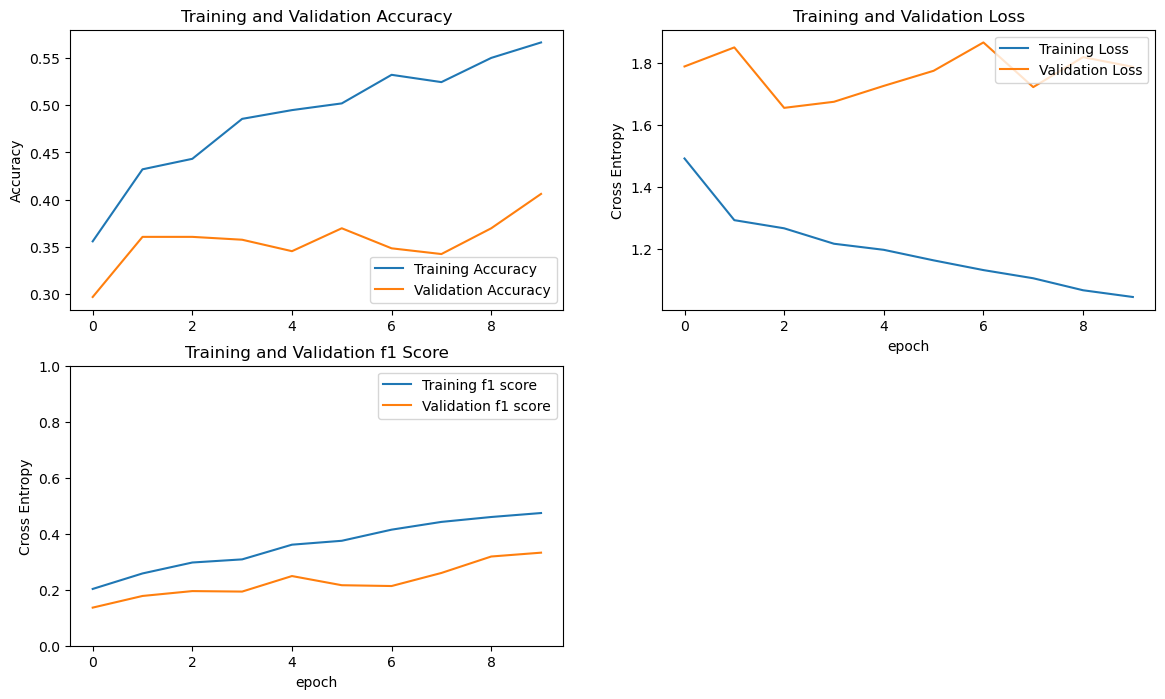

In [37]:
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(f1_m, label='Training f1 score')
plt.plot(val_f1_m, label='Validation f1 score')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
# plt.ylim([0,1.0])
plt.title('Training and Validation f1 Score')
plt.xlabel('epoch')

plt.show()


In [38]:
loss_init, accuracy_init, f1_init = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_init)

2023-08-31 20:30:39.667365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [670]
	 [[{{node Placeholder/_4}}]]
2023-08-31 20:30:39.668090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [670]
	 [[{{node Placeholder/_4}}]]


21/21 [==============================] - 6s 255ms/step - loss: 1.8558 - accuracy: 0.3403 - f1_m: 0.2847
Test accuracy : 0.34029850363731384


In [65]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions[1]

2023-08-31 21:30:44.857658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]


array([0.14286613, 0.4750032 , 0.23233643, 0.09957483, 0.05021942],
      dtype=float32)

In [66]:
predictions = tf.nn.softmax(predictions)

In [75]:
image_batch[0]

array([[[ 25.      ,  77.      , 160.      ],
        [ 25.      ,  77.      , 160.      ],
        [ 25.      ,  77.      , 160.      ],
        ...,
        [ 18.393898,  64.71441 , 128.9585  ],
        [ 19.542274,  63.542274, 125.586914],
        [ 19.561108,  63.989002, 128.45471 ]],

       [[ 25.      ,  77.      , 160.      ],
        [ 25.      ,  77.      , 160.      ],
        [ 25.      ,  77.      , 160.      ],
        ...,
        [ 38.97558 ,  83.72547 , 145.10042 ],
        [ 44.212597,  85.34653 , 144.91348 ],
        [ 37.799294,  80.2169  , 142.2415  ]],

       [[ 25.      ,  77.      , 160.      ],
        [ 25.      ,  77.      , 160.      ],
        [ 25.      ,  77.      , 160.      ],
        ...,
        [ 63.09669 , 105.00069 , 163.91444 ],
        [ 63.91823 , 104.91823 , 160.91823 ],
        [ 56.11043 ,  97.92964 , 157.2065  ]],

       ...,

       [[193.15404 , 109.154045,  72.154045],
        [197.99193 , 113.991936,  76.991936],
        [200.90402 , 1

In [67]:
# Apply a softmax since our model returns hot-encoded
predictions = tf.where(predictions < 0.20, 0, 1)
print('Predictions:\n', predictions.numpy())
print('number of predictions : ', len(predictions))
print('Labels:\n', label_batch)

Predictions:
 [[0 1 0 0 0]
 [0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 1 1 0]
 [0 1 1 0 0]
 [0 0 1 0 0]
 [1 0 1 0 0]
 [1 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [1 1 0 0 0]
 [1 0 1 0 0]
 [0 1 0 0 0]
 [1 1 1 0 0]
 [1 1 0 0 0]
 [1 0 1 0 0]
 [1 0 1 1 0]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [0 0 1 1 0]
 [0 0 1 1 0]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [1 1 0 0 0]
 [1 0 1 0 0]
 [0 1 0 0 0]
 [1 0 0 1 0]
 [0 1 0 0 0]
 [0 1 1 0 0]
 [0 1 0 0 0]
 [0 1 1 0 0]
 [1 1 0 0 0]]
number of predictions :  32
Labels:
 [[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0.

In [68]:
class_names = train_dataset.class_names

In [69]:
class_names

['Heart', 'Oblong', 'Oval', 'Round', 'Square']

In [70]:
class_names[predictions[1].numpy().tolist().index(1)]

'Oblong'

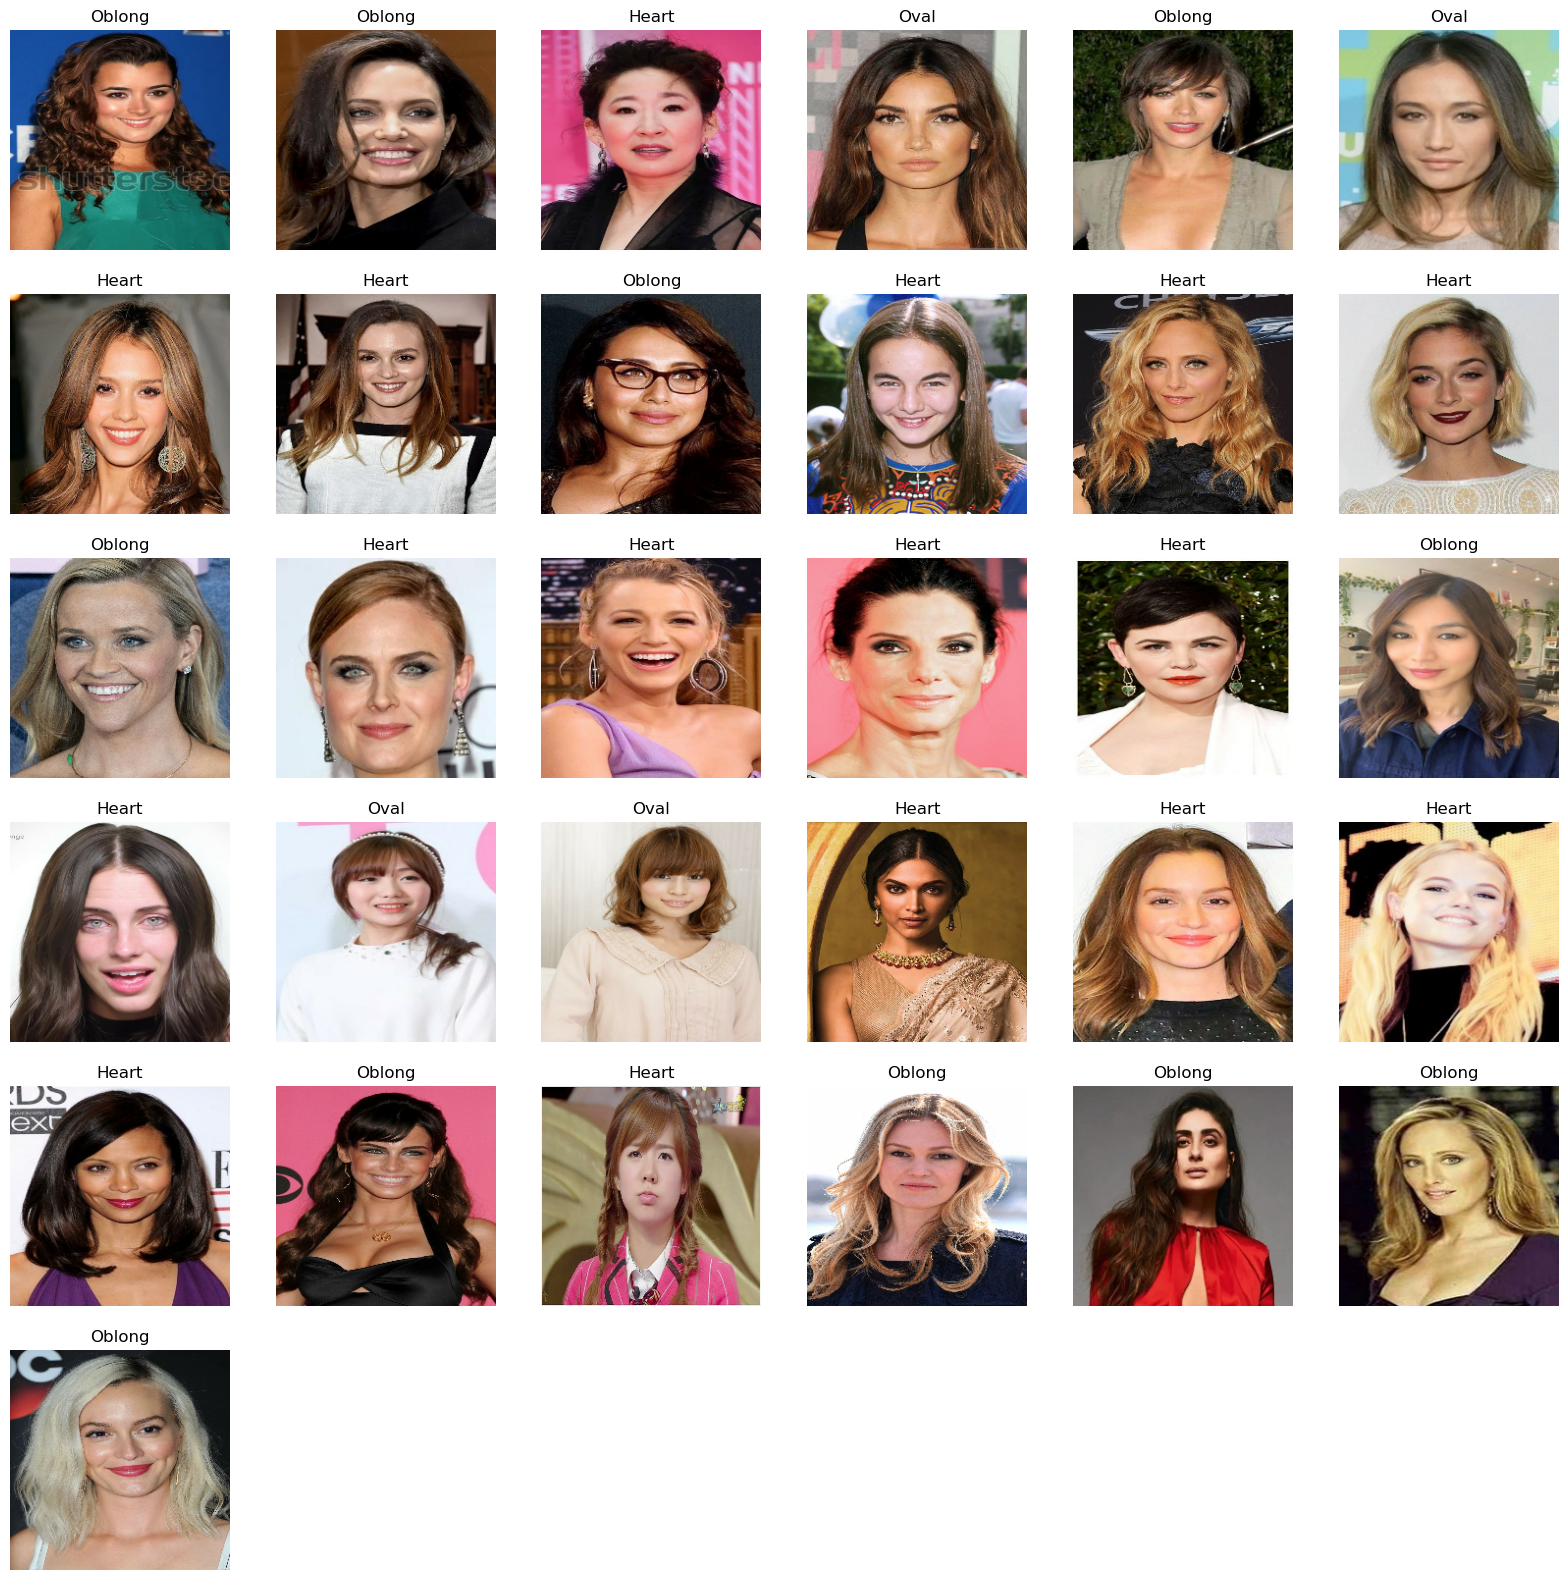

In [71]:
plt.figure(figsize=(20, 20))
for i in range(31):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(label= class_names[predictions[i].numpy().tolist().index(1)])
    plt.axis("off")

In [79]:
data = load('test_data/oblong.jpg')
face_files = np.array(data['filenames'])
face_files

NotADirectoryError: [Errno 20] Not a directory: './test_data/oblong.jpg'

In [ ]:

model.predict()